In [1]:
%matplotlib inline

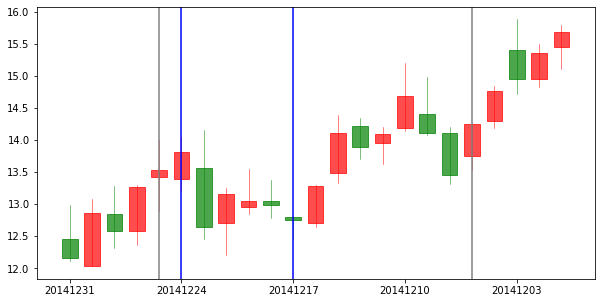

In [2]:
# 样本重叠问题画图
import tushare as ts
import mpl_finance
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np


# 获取数据
token = '82f17f80a6f62681bcbf105689d892a9559a4e65af4045adb472eaf0'
ts.set_token(token)

start_date = "2014-12-01"
end_date = "2015-01-01"

df1 = ts.pro_bar('600000.SH', adj='qfq',
                 start_date=start_date, end_date=end_date)
df1.sort_values(by="trade_date", inplace=True)
df1['dates'] = np.arange(0, len(df1))


# 画图
fig, ax = plt.subplots(figsize=(10, 5))
mpl_finance.candlestick_ochl(
    ax=ax, quotes=df1[['dates', 'open', 'close', 'high', 'low']].values,
    width=0.7,
    colorup='r',
    colordown='g',
    alpha=0.7)

date_tickers = df1["trade_date"]


def format_date(x, pos):
    if x < 0 or x > len(date_tickers)-1:
        return ''
    return date_tickers[int(x)]


ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))

plt.axvline(x=4, ls="-", c="grey")
plt.axvline(x=18, ls="-", c="grey")

plt.axvline(x=5, ls="-", c="blue")
plt.axvline(x=10, ls="-", c="blue")

In [3]:
import tushare as ts
import pandas as pd

token = '82f17f80a6f62681bcbf105689d892a9559a4e65af4045adb472eaf0'
ts.set_token(token)
start_date = "2000-01-01"
end_date = "2015-01-01"

df1 = ts.pro_bar('600000.SH', adj='qfq',
                 start_date=start_date, end_date=end_date)


feature_x = pd.read_csv("../datasets/ADF_adjust_train.csv")
feature_y = pd.read_csv("../datasets/label_train.csv")


feature_y.head()

,trade_date,FirstTime,return,label
0,2000-02-15,2000-03-14,0.030488,0.0
1,2000-02-16,2000-03-15,0.049689,0.0
2,2000-02-17,2000-03-09,0.062893,1.0
3,2000-02-18,2000-03-17,0.069620,0.0
4,2000-02-21,2000-03-20,-0.015152,0.0


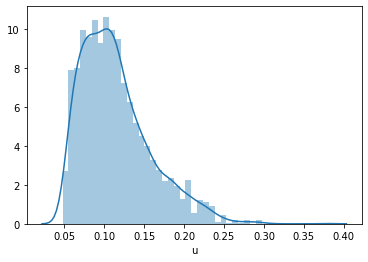

In [4]:
# start_date_list, end_date_list


import seaborn as sns


def get_independence(sr1, sr2, date_sr):
    C = pd.DataFrame()
    C["date"] = date_sr
    C["count"] = 0
    C["date"] = pd.to_datetime(C["date"])
    for start_date, end_date in zip(sr1, sr2):
        C.loc[(C["date"] > start_date) & (C["date"] <= end_date), "count"] += 1
    result = pd.DataFrame()
    result["start_date"] = sr1
    for i, (start_date, end_date) in enumerate(zip(sr1, sr2)):
        c = C.loc[(C["date"] > start_date) & (C["date"] <= end_date), "count"]
        result.loc[i, "p"] = ((1/(c+1)).sum())/len(c)
    return result


independence = get_independence(
    feature_y["trade_date"], feature_y["FirstTime"], df1["trade_date"])

sns.distplot(independence["p"])
plt.xlabel("u")
plt.show()

In [5]:
import numpy as np

# df:trade_date,FirstTime


def seqBoostStrap(df, date_list, per_size=100, max_len=None):
    result = []
    if max_len is None:
        max_len = len(df)

    start_date_list, end_date_list = [], []

    while len(result) < max_len:
        prob = pd.DataFrame()
        prob["date"] = df["trade_date"]
        for i in range(len(df)):
            start_date_tmp = df.loc[i, "trade_date"]
            end_date_tmp = df.loc[i, "FirstTime"]
            independence = get_independence(
                start_date_list+[start_date_tmp], end_date_list+[end_date_tmp], date_list)
            # 时间衰减
            prob.loc[i, "p"] = independence.iloc[-1]["p"]*(i+len(df))/len(df)/2
        prob["p"] /= sum(prob["p"])
        p = np.random.choice(df["trade_date"], size=per_size,
                             replace=True, p=prob["p"])
        result = np.append(result, p)
    return result


result = seqBoostStrap(feature_y, df1["trade_date"])

In [6]:
result

array(['2014-01-10', '2011-08-23', '2001-08-31', ..., '2013-06-26',
       '2001-05-17', '2013-05-17'], dtype=object)